# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

---------

# 1. Análisis Exploratorio de Datos

## 1.1 Librerías y bases de datos
Importamos las librerías requeridas para el desarrolllo del proyecto.

In [1]:
import pandas as pd
import numpy as np 
import prettytable as pt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importamos la librería Natural Language Tokenizer
import nltk

#Diccionario de stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('spanish'))

Importamos las bases de datos: *dev*, *test* y *train* de los reviews de productos de amazon.

In [3]:
dev = pd.read_json('dataset_es_dev.json', lines = True)
test = pd.read_json('dataset_es_test.json', lines = True)
train = pd.read_json('dataset_es_train.json', lines = True)
sets = [dev,test,train]

## 1.2 Exploración general de los datos

Iniciamos revisando los features y tamaño de los diferentes sets de datos.

In [4]:
cols = pt.PrettyTable()
cols.add_column('DEV', dev.columns.tolist())
cols.add_column('TEST', test.columns.tolist())
cols.add_column('TRAIN', train.columns.tolist())
print(cols)

+------------------+------------------+------------------+
|       DEV        |       TEST       |      TRAIN       |
+------------------+------------------+------------------+
|    review_id     |    review_id     |    review_id     |
|    product_id    |    product_id    |    product_id    |
|   reviewer_id    |   reviewer_id    |   reviewer_id    |
|      stars       |      stars       |      stars       |
|   review_body    |   review_body    |   review_body    |
|   review_title   |   review_title   |   review_title   |
|     language     |     language     |     language     |
| product_category | product_category | product_category |
+------------------+------------------+------------------+


In [5]:
sizes = pt.PrettyTable()
sizes.add_column('DEV', dev.shape)
sizes.add_column('TEST', test.shape)
sizes.add_column('TRAIN', train.shape)
print(sizes)

+------+------+--------+
| DEV  | TEST | TRAIN  |
+------+------+--------+
| 5000 | 5000 | 200000 |
|  8   |  8   |   8    |
+------+------+--------+


Como observación inicial revisamos las primeras 5 instancias del dataset *dev* . Donde observamos los id del producto, reviewer y review, la cantidad de estrellas el título y descripción del review, el lenguaje y la categoría del producto.

In [6]:
dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


El feature de lenguaje tiene un único valor de *es*, indicando el idioma español. No se usará, así que se elimina.

In [7]:
print(dev['language'].value_counts(),'\n',train['language'].value_counts(),'\n',test['language'].value_counts())
dev.drop(['language'],axis=1,inplace=True)
train.drop(['language'],axis=1,inplace=True)
test.drop(['language'],axis=1,inplace=True)

es    5000
Name: language, dtype: int64 
 es    200000
Name: language, dtype: int64 
 es    5000
Name: language, dtype: int64


Con el objetivo de tener una idea general de los datasets, de los productos y de los promedios en cantidad de estrellas por set de datos para comparar con los resultados finales del modelo de predicción, se desarrollan las siguientes gráficas:

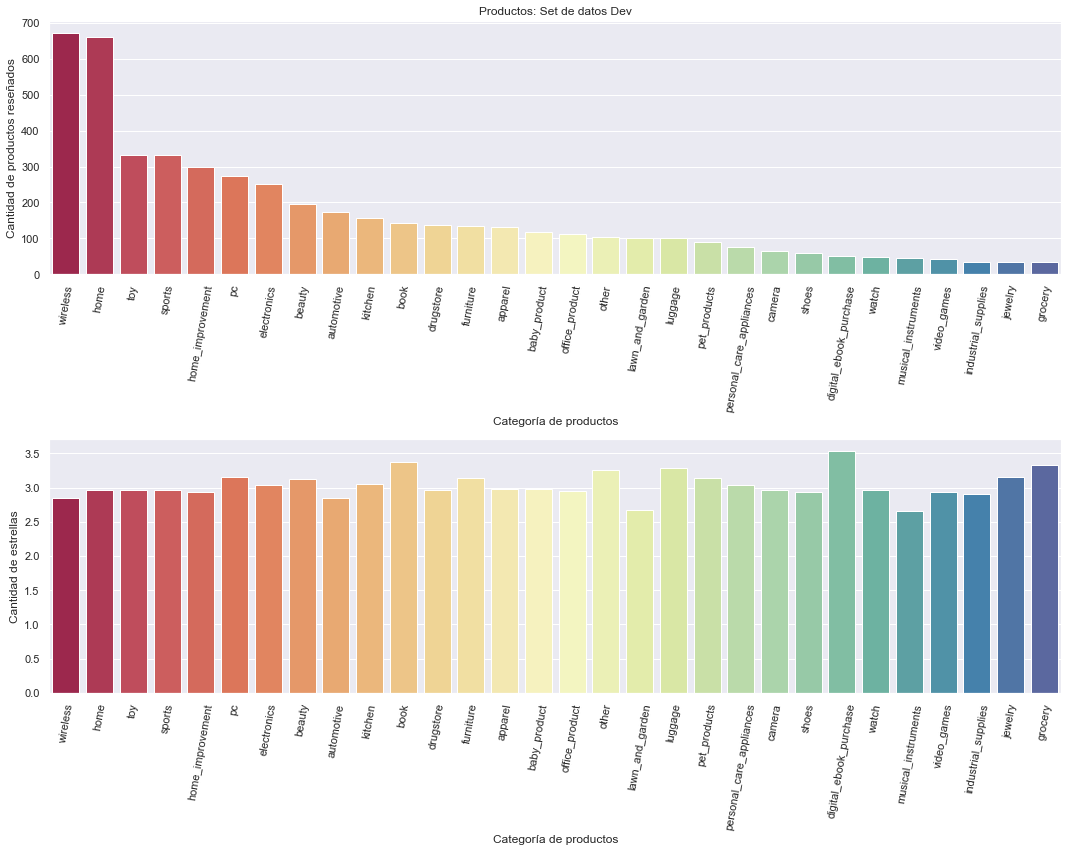

In [8]:
fig, axes = plt.subplots(2,1,figsize=(15, 12))
categoria_producto = dev['product_category'].value_counts();
promedio_estrellas = dev.groupby("product_category", as_index=False).mean()


sns.countplot(ax=axes[0], data=dev, x='product_category', palette="Spectral", order=categoria_producto.index)
axes[0].tick_params(axis='x', labelrotation= 80)
axes[0].set(xlabel='Categoría de productos',ylabel='Cantidad de productos reseñados',title='Productos: Set de datos Dev')
sns.barplot(ax=axes[1], x = "product_category", y = "stars", data = promedio_estrellas, palette="Spectral", order=categoria_producto.index);
axes[1].tick_params(axis='x', labelrotation= 80)
axes[1].set(xlabel='Categoría de productos',ylabel='Cantidad de estrellas')
plt.tight_layout();

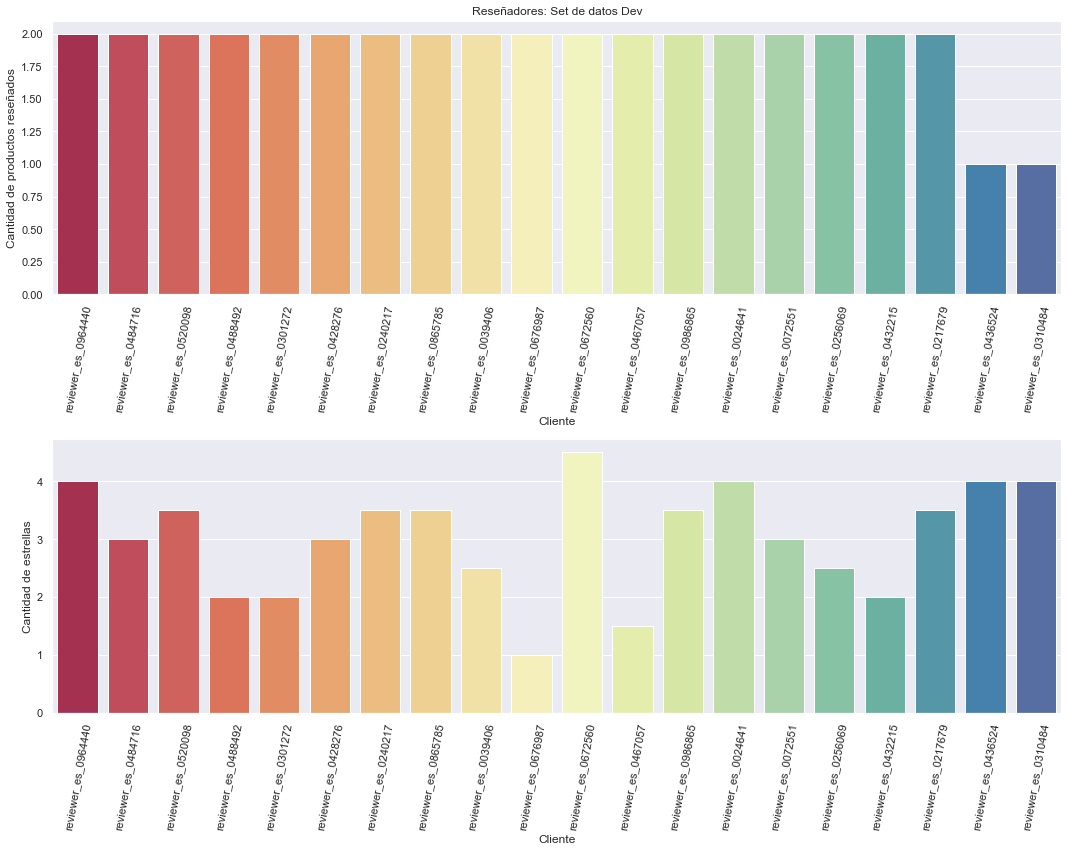

In [9]:
fig, axes = plt.subplots(2,1,figsize=(15, 12))
categoria_cliente = dev['reviewer_id'].value_counts()[:20];
promedio_estrellas = dev.loc[dev.reviewer_id.isin(categoria_cliente.index)].groupby("reviewer_id", as_index=False).mean()

sns.countplot(ax=axes[0], data=dev, x='reviewer_id', palette="Spectral", order=categoria_cliente.index)
axes[0].tick_params(axis='x', labelrotation= 80)
axes[0].set(xlabel='Cliente',ylabel='Cantidad de productos reseñados',title='Reseñadores: Set de datos Dev')
sns.barplot(ax=axes[1], x = "reviewer_id", y = "stars", data = promedio_estrellas, palette="Spectral", order=categoria_cliente.index);
axes[1].tick_params(axis='x', labelrotation= 80)
axes[1].set(xlabel='Cliente',ylabel='Cantidad de estrellas')
plt.tight_layout();

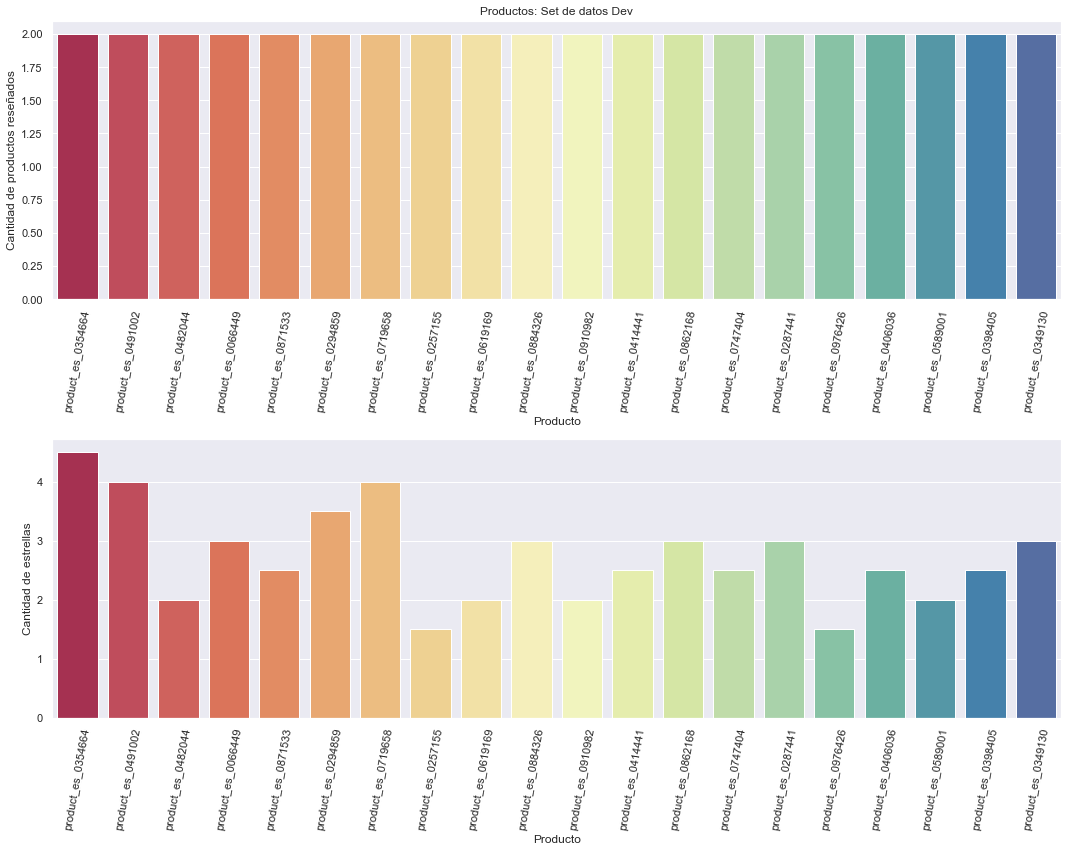

In [10]:
fig, axes = plt.subplots(2,1,figsize=(15, 12))
producto = dev['product_id'].value_counts()[:20];
promedio_estrellas = dev.loc[dev.product_id.isin(producto.index)].groupby("product_id", as_index=False).mean()

sns.countplot(ax=axes[0], data=dev, x='product_id', palette="Spectral", order=producto.index)
axes[0].tick_params(axis='x', labelrotation= 80)
axes[0].set(xlabel='Producto',ylabel='Cantidad de productos reseñados',title='Productos: Set de datos Dev')
sns.barplot(ax=axes[1], x = "product_id", y = "stars", data = promedio_estrellas, palette="Spectral", order=producto.index);
axes[1].tick_params(axis='x', labelrotation= 80)
axes[1].set(xlabel='Producto',ylabel='Cantidad de estrellas')
plt.tight_layout();

Como podemos ver, el tipo de producto no tiene un efecto muy fuerte en la puntuación promedio de este, la categoría mejor puntuada en promedio son los eBoooks, cuya calidad es estándar y su puntuacion depende de cuanto le guste al comprador el contenido. Y el reseñador o el producto tampoco son muy relevantes, ya que ambos tienen frecuencia máxima de 2 instancias: no hay reseñadores con alto volumen de reseñas ni positivas ni negativas que podrían afectar el modelo con maneras de escribir específicas a una sola persona, ni productos con muchos reviews que podrian afectar el modelo con palabras específicas a ese producto.

Verificamos la distribución  de estrellas en los set de datos:

In [11]:
dis_stars = pt.PrettyTable()
dis_stars.add_column('Estrellas', [1,2,3,4,5])
dis_stars.add_column('set Dev', dev.stars.value_counts().tolist())
dis_stars.add_column('set Train', train.stars.value_counts().tolist())
dis_stars.add_column('set Test', test.stars.value_counts().tolist())
print(dis_stars)

+-----------+---------+-----------+----------+
| Estrellas | set Dev | set Train | set Test |
+-----------+---------+-----------+----------+
|     1     |   1000  |   40000   |   1000   |
|     2     |   1000  |   40000   |   1000   |
|     3     |   1000  |   40000   |   1000   |
|     4     |   1000  |   40000   |   1000   |
|     5     |   1000  |   40000   |   1000   |
+-----------+---------+-----------+----------+


Las etiquetas están perfectamente distribuidas, indicando que las entradas del modelo van a estar balanceadas.

Finalmente, revisamos la cantidad de palabras que tienen los reviews:

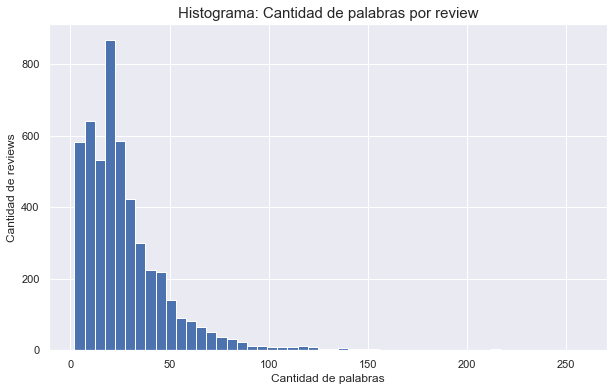

In [12]:
fig = plt.figure(figsize = (10,6))
ax = plt.axes()
words_per_review = dev.review_body.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 50)
ax.set(xlabel='Cantidad de palabras',ylabel='Cantidad de reviews')
plt.title('Histograma: Cantidad de palabras por review', fontsize=15);

In [13]:
print('La cantidad promedio de palabras por review es de:',words_per_review.mean())

La cantidad promedio de palabras por review es de: 27.572


# 2. Procesamiento de Lenguaje Natural

## 2.1. Pre-procesamiento de los datos

Con el fin de normalizar todos los datos para su evaluación se aplica la función *.lower* para que todos los carácteres estén en minúscula y evitar errores en los siguientes pasos.

In [14]:
for set in sets:
    set.review_body = set.review_body.apply(lambda x: x.lower())
    set.review_title = set.review_title.apply(lambda x: x.lower())

In [15]:
test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,estoy muy decepcionado con el vendedor ya que ...,estafa en el envío,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,mi valoración no es sobre el producto sino sob...,estafa de amazon,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,pues tenía interés en este libro y probé la ve...,no conseguí pasar de la portada en kindle,digital_ebook_purchase


Clasificamos los reviews como positivos para los que tienen 4 o 5 estrellas y negativos para los que tienen 3, 2 o 1 estrella.

In [16]:
for set in sets:
    set['binario'] = np.where(set.stars > 3, 1, 0)
    print(set['binario'].value_counts())

0    3000
1    2000
Name: binario, dtype: int64
0    3000
1    2000
Name: binario, dtype: int64
0    120000
1     80000
Name: binario, dtype: int64


In [17]:
# Removing neutral reviews 
# amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]

## 2.2 Tokenización

Transformamos los reviews mediante un tokenizado para evaluar los comentarios por palabra. Adicionalmente eliminamos los caracteres especiales como signos de puntuación y emojis.

In [18]:
def tokenizar(df):

	new_df = df[['review_id','stars','binario','review_body','review_title']]

	new_df['body_token'] = new_df.review_body.apply(lambda x: nltk.tokenize.word_tokenize(x))
	new_df['title_token'] = new_df.review_title.apply(lambda x: nltk.tokenize.word_tokenize(x))

	characters_list = new_df.body_token.apply(lambda x: [each for each in list(x) if not each.isalpha() and each != ' '])
	#characters_list = characters_list.append(new_df.review_title.apply(lambda x: [each for each in list(x) if not str(each).isalpha() and each != ' ']))
	characters = [item for sublist in characters_list for item in sublist]
	print('Caracteres especiales eliminados: ',np.unique(characters))

	for column in ['body_token', 'title_token']:
		for i in range(len(new_df.body_token)):
			new_df[column][i] = [word for word in new_df[column][i] if word not in characters]
			new_df[column][i] = [word for word in new_df[column][i] if word not in stopwords]

	return new_df

In [19]:
dev_token = tokenizar(dev)

Caracteres especiales eliminados:  ['!' '#' '%' "'" "''" "'tablet" '(' ')' '*' '+' '+++' ',' ',puede' '-'
 '-5' '-fregadero-' '-precio' '.' '..' '...' '....' '.....' '......'
 '.......' '........' '.........' '.aun' '.buen' '.con' '.creo' '.da'
 '.después' '.envío' '.esta' '.faltaban' '.gracias' '.i' '.la' '.le' '.me'
 '.ni' '.no' '.pero' '.principios' '.se' '.un' '.vendedor' '.y' '/'
 '/precio' '0' '0,5' '0.' '0.1' '1' '1,2' '1,5' '1,60' '1,69' '1,70'
 '1,75' '1-2' '1.' '1.6.' '1/2' '1/4' '10' '10,1' '10-12' '10-15' '10.'
 '10/10' '10/100/1000' '100' '1000' '100x100' '100€' '1080' '10cm' '10mm'
 '10€' '11' '12' '125' '12m' '12v' '12º' '13' '130' '135' '14' '15' '15,6'
 '15.6' '150' '150w' '150x190' '15h' '15min' '16' '16/05/2019' '160.'
 '16gb' '17' '18' '180' '180gr' '18kg' '18º' '19' '19,95€' '19,99€' '1a'
 '1h' '1°' '1º' '1€' '2' '2,35' '2-3' '2-5' '2.' '2.4ghz' '2.5' '2/3' '20'
 '20,5' '200' '2000' '20000' '2001.' '2006' '2007.' '200w' '200€' '2011'
 '2011.' '2017' '2017.' '2018' 

Como resultado observamos que las columnas tokenizadas estan conformadas por listas de las palabras representativas de los comentarios, en minúsculas y sin signos de puntuación:

In [20]:
dev_token.head(3)

,review_id,stars,binario,review_body,review_title,body_token,title_token
0,es_0417480,1,0,"malisimo, muy grande demasiado aparatoso y mal...",mala compra,"[malisimo, grande, demasiado, aparatoso, mal, ...","[mala, compra]"
1,es_0180432,1,0,no he recibido el pedido no la devolución,no lo he recibido,"[recibido, pedido, devolución]",[recibido]
2,es_0144850,1,0,"tengo que buscar otro sistema, este no funcion...",que no aprieta bien en el manillar,"[buscar, sistema, funciona, bien, abrazadera, ...","[aprieta, bien, manillar]"


## 2.3 Lemmatización

Evaluamos la librería Spacy para realizar la lemmatización:

In [21]:
import spacy
#spacy.prefer_gpu()
nlp = spacy.load("es_core_news_sm")

In [22]:
Lemma_prueba = pd.DataFrame(columns = ['Token','Token Text','Token Pos', 'Token Lemma'])
dev_token['body_lemma'] = dev_token.body_token.apply(lambda x: ' '.join(x))
doc = nlp(dev_token['body_lemma'][0])
for token in doc:
    Lemma_prueba = Lemma_prueba.append({'Token':token, 'Token Text':token.text, 'Token Pos':token.pos_,
    'Token Lemma':token.lemma_}, ignore_index=True)
print(Lemma_prueba)

       Token Token Text Token Pos Token Lemma
0   malisimo   malisimo      NOUN    malisimo
1     grande     grande       ADJ      grande
2  demasiado  demasiado       ADV   demasiado
3  aparatoso  aparatoso       ADJ   aparatoso
4        mal        mal       ADV         mal
5  protector  protector      NOUN   protector
6   pantalla   pantalla      VERB   pantallar


In [23]:
dev_token['body_lemma'] = dev_token.body_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])

In [24]:
dev_token['title_lemma'] = dev_token.title_token.apply(lambda x: ' '.join(x))
dev_token['title_lemma'] = dev_token.title_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])

In [25]:
dev_token.head()

,review_id,stars,binario,review_body,review_title,body_token,title_token,body_lemma,title_lemma
0,es_0417480,1,0,"malisimo, muy grande demasiado aparatoso y mal...",mala compra,"[malisimo, grande, demasiado, aparatoso, mal, ...","[mala, compra]","[malisimo, grande, demasiado, aparatoso, mal, ...","[malo, compra]"
1,es_0180432,1,0,no he recibido el pedido no la devolución,no lo he recibido,"[recibido, pedido, devolución]",[recibido],"[recibido, pedido, devolución]",[recibido]
2,es_0144850,1,0,"tengo que buscar otro sistema, este no funcion...",que no aprieta bien en el manillar,"[buscar, sistema, funciona, bien, abrazadera, ...","[aprieta, bien, manillar]","[buscar, sistema, funcionar, bien, abrazaderar...","[aprieta, bien, manillar]"
3,es_0339629,1,0,utilicé las brocas de menor diámetro y se me d...,brocas de mantequilla,"[utilicé, brocas, menor, diámetro, doblaron, v...","[brocas, mantequilla]","[utilicé, broca, menor, diámetro, doblar, vari...","[broca, mantequillar]"
4,es_0858362,1,0,no me gusta su olor a viejo y aspecto malo,no me gusta,"[gusta, olor, viejo, aspecto, malo]",[gusta],"[gustar, olor, viejo, aspecto, malo]",[gustar]


## 2.4 Análisis de Frecuencia de las palabras

De acuerdo con el procesamiento anterior obtenemos una primera versión de la frecuencia de palabras que en general determinan si un comentario es positivo o negativo respecto a la clasficación propuesta. Para analizar desarrollamos las gráficas de frecuencia:

In [26]:
#Función de frecuencias de las palabras
def get_freqs(df):

	# Separamos las reseñas malas de las buenas
	df_malos = df.loc[df.stars.isin([1,2,3])]
	df_buenos = df.loc[df.stars.isin([4,5])]

	df_malos.reset_index(inplace= True)
	df_buenos.reset_index(inplace= True)

	# Guardamos todos los titulos y reseñas buenos y malos en listas separadas
	df_malos_titulos = []
	df_malos_reviews = []
	for i in range(len(df_malos.review_title)):
		df_malos_titulos.append(df_malos.title_lemma[i])
		df_malos_reviews.append(df_malos.body_lemma[i])
	df_malos_titulos = [item for elem in df_malos_titulos for item in elem]
	df_malos_reviews = [item for elem in df_malos_reviews for item in elem]

	df_buenos_titulos = []
	df_buenos_reviews = []
	for i in range(len(df_buenos.review_title)):
		df_buenos_titulos.append(df_buenos.title_lemma[i])
		df_buenos_reviews.append(df_buenos.body_lemma[i])
	df_buenos_titulos = [item for elem in df_buenos_titulos for item in elem]
	df_buenos_reviews = [item for elem in df_buenos_reviews for item in elem]

	# Hacemos 4 dataframes con las frecuencias de las palabras
	df_malos_titulos_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_malos_titulos), orient = 'index')
	df_malos_titulos_freq['word'] = df_malos_titulos_freq.index
	df_malos_titulos_freq.sort_values(by = 0, ascending= False, inplace = True)

	df_malos_reviews_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_malos_reviews), orient = 'index')
	df_malos_reviews_freq['word'] = df_malos_reviews_freq.index
	df_malos_reviews_freq.sort_values(by = 0, ascending= False, inplace = True)

	df_buenos_titulos_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_buenos_titulos), orient = 'index')
	df_buenos_titulos_freq['word'] = df_buenos_titulos_freq.index
	df_buenos_titulos_freq.sort_values(by = 0, ascending= False, inplace = True)
	
	df_buenos_reviews_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_buenos_reviews), orient = 'index')
	df_buenos_reviews_freq['word'] = df_buenos_reviews_freq.index
	df_buenos_reviews_freq.sort_values(by = 0, ascending= False, inplace = True)

	return df_malos_titulos_freq, df_malos_reviews_freq, df_buenos_titulos_freq, df_buenos_reviews_freq

In [27]:
dev_mal_tit, dev_mal_rev, dev_buen_tit, dev_buen_rev = get_freqs(dev_token)

Graficamos lo resultados de frecuencias:

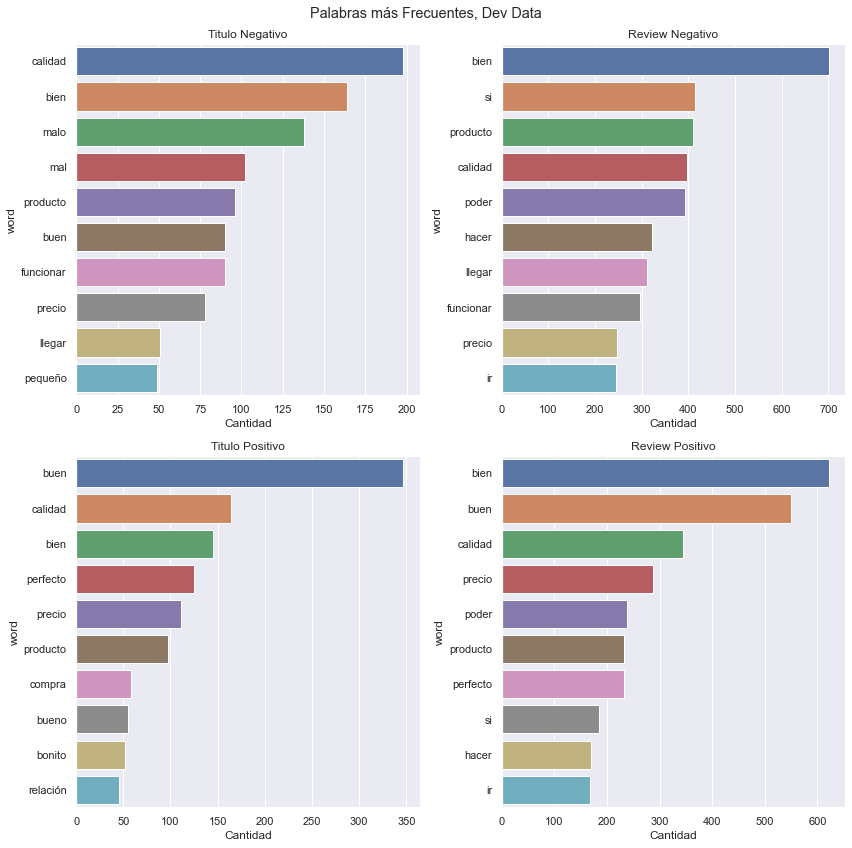

In [28]:
plt.figure(figsize= (12,12))
plt.suptitle('Palabras más Frecuentes, Dev Data')

plt.subplot(221)
sns.barplot(x = dev_mal_tit[0][:10], y = dev_mal_tit.word[:10])
plt.title('Titulo Negativo')
plt.xlabel('Cantidad')

plt.subplot(222)
sns.barplot(x = dev_mal_rev[0][:10], y = dev_mal_rev.word[:10])
plt.title('Review Negativo')
plt.xlabel('Cantidad')

plt.subplot(223)
sns.barplot(x = dev_buen_tit[0][:10], y = dev_buen_tit.word[:10])
plt.title('Titulo Positivo')
plt.xlabel('Cantidad')

plt.subplot(224)
sns.barplot(x = dev_buen_rev[0][:10], y = dev_buen_rev.word[:10])
plt.title('Review Positivo')
plt.xlabel('Cantidad')

plt.tight_layout();

Las gráficas demuestran que hay muchas palabras que son muy comunes en todos los reviews y que se repiten tanto en los comentarios positivos como en los negativos como por ejemplo *calidad* y *producto*;. Por tanto, se decide eliminar algunas de las palabras más repetidas en todos los comentarios para evaluar unicamente las palabras representativas que permitan realizar la clasificación.

In [29]:
all_lemmas = []
for i in range(len(dev_token.body_lemma)):
	all_lemmas.append(dev_token.body_lemma[i])
all_lemmas = [item for elem in all_lemmas for item in elem]

one_percentile = int(len(np.unique(all_lemmas)) * 0.01)

#1% de las palabras más comunes del dataset
from collections import Counter
count_freq = Counter(all_lemmas).most_common(one_percentile)
count_notfreq = Counter(all_lemmas).most_common()[-one_percentile:]

In [30]:
a_remover = [word for word,val in count_freq[:20]] + [word for word,val in count_notfreq]
 

In [31]:
#Código para remover las palabras
dev_token.body_lemma = dev_token.body_lemma.apply(lambda x: [word for word in x if word not in a_remover])
dev_token.title_lemma = dev_token.title_lemma.apply(lambda x: [word for word in x if word not in a_remover])

De forma que las nuevas gráficas resultante son las siguientes:

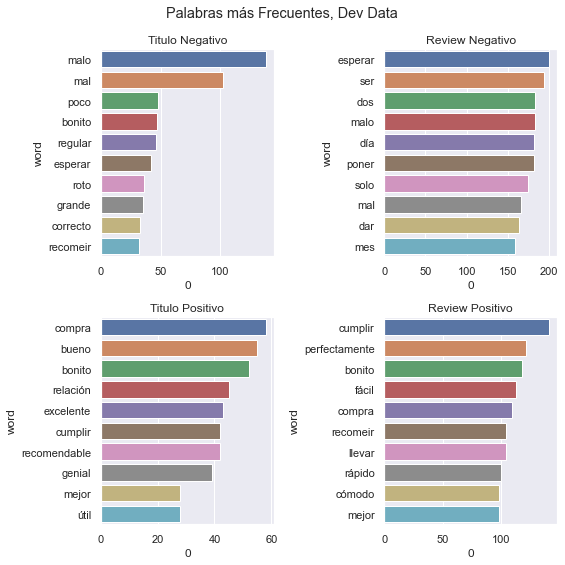

In [32]:
dev_mal_tit, dev_mal_rev, dev_buen_tit, dev_buen_rev = get_freqs(dev_token)

plt.figure(figsize= (8,8))
plt.suptitle('Palabras más Frecuentes, Dev Data')

plt.subplot(221)
sns.barplot(x = dev_mal_tit[0][:10], y = dev_mal_tit.word[:10])
plt.title('Titulo Negativo')

plt.subplot(222)
sns.barplot(x = dev_mal_rev[0][:10], y = dev_mal_rev.word[:10])
plt.title('Review Negativo')

plt.subplot(223)
sns.barplot(x = dev_buen_tit[0][:10], y = dev_buen_tit.word[:10])
plt.title('Titulo Positivo')

plt.subplot(224)
sns.barplot(x = dev_buen_rev[0][:10], y = dev_buen_rev.word[:10])
plt.title('Review Positivo')

plt.tight_layout()
plt.show();

Verificamos que se eliminan las palabras más comunes que no aportaban información valiosa a la clasificación y nos quedamos con palabras más significativas como: *recomendable* o *útil* para comentarios positivos, y *defectuoso* o *devolver* para comentarios negativos.

Exportamos el dataset dev, para desarrollar el modelo de Machine Learning.

In [33]:
# Exportamos nuestro dataset transformado
dev_token.to_csv('dataset_dev_token.csv')

# 3. Modelo de Machine Learning

## 3.1 Ingeniería de Features

Con el dataset tokenizado, utilizaremos el cuerpo de los reviews y realizaremos modelos que clasifiquen los reviews de manera binaria y posteriormente en las 5 estrellas. Para esto definimos las palabras como vectores usando la estrategia Bag of Words que guarda para cada entrada un vector donde todas las palabras del corpus son una variable y el numero que la funcion le asigna es las veces que aparece en la reseña particular.

Transformamos el dataset asi:

In [34]:
#Ahora si, insumos para la prediccion
dev_token = pd.read_csv('dataset_dev_token.csv')
data = dev_token[['body_lemma','stars','binario']]
data.head()

,body_lemma,stars,binario
0,"['malisimo', 'grande', 'demasiado', 'aparatoso...",1,0
1,"['recibido', 'pedido', 'devolución']",1,0
2,"['buscar', 'sistema', 'abrazaderar', 'llevar',...",1,0
3,"['utilicé', 'broca', 'menor', 'diámetro', 'dob...",1,0
4,"['gustar', 'olor', 'viejo', 'aspecto', 'malo']",1,0


In [35]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizador=CountVectorizer()
data_vec = vectorizador.fit_transform(data.body_lemma)

# Tomamos las palabras
all_words = vectorizador.get_feature_names()

X_data = data_vec.toarray()

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, data['binario'], test_size = 0.3, random_state=42) 

In [37]:
# miramos que la distribución haya quedado balanceada en train y test, como lo estaba en el original (60/40)
print(f'En train, tenemos {round((y_train.value_counts() / y_train.shape[0])[0]*100, 2)} % de reviews negativas y en test {(y_test.value_counts() / y_test.shape[0])[0]*100} %')

En train, tenemos 59.74 % de reviews negativas y en test 60.6 %


## 3.2 Métricas de evaluación

Definimos las siguientes funciones con las métricas de evaluación para los modelos.

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["Negativo","Positivo"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

## 3.3 Modelo Benchmark
Ahora, a partir de los resultados procesados y organizados, procedemos a aplicar los modelos de Machine Learning para obtener la clasificación y número de estrellas por comentario.

Iniciaremos estableciendo como Benchmark el modelo que mejor clasifique los reviews de manera binaria: buenos o malos. Para esto evaluaremos un random forest y una regresión logística, utilizando el dataset tokenizado y la columna binario previamente establecida en la que 4 y 5 estrellas hacen un buen review y 1, 2 o 3 hacen uno malo. 

### 3.3.1 Random Forest Classifier

Accuracy:  0.702
RandomForestClassifier(max_depth=30, random_state=42)


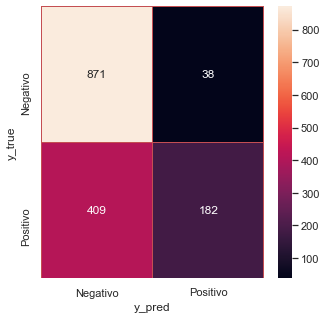

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [10,20,50,70,100,150],
		  'max_depth': [2,5,7,10,25,20,30]}
rf = RandomForestClassifier(random_state=42)
rfo = GridSearchCV(rf, params)
rfo.fit(X_train,y_train)

print("Accuracy: ",rfo.best_estimator_.score(X_test,y_test))
print(rfo.best_estimator_)

y_pred=rfo.predict(X_test)
confusion(y_test,y_pred)

Evaluación de los reviews mal predichos

In [101]:
Errores_pos_rf = []
Errores_neg_rf = []
for i in range(1500):
    #print(y_test.iloc[i], y_pred[i])
    if y_test.iloc[i] != y_pred[i]:
        if y_test.iloc[i] == 0:
            Errores_neg_rf.append(y_test.index[i])
        else:
            Errores_pos_rf.append(y_test.index[i])
print(len(Errores_pos_rf))
print(len(Errores_neg_rf))

409
38


In [102]:
print(data.loc[Errores_neg_rf].groupby('stars').body_lemma.count())

stars
1     2
2     8
3    28
Name: body_lemma, dtype: int64


In [103]:
print(data.loc[Errores_pos_rf].groupby('stars').body_lemma.count())

stars
4    215
5    194
Name: body_lemma, dtype: int64


Se revisaran algunos de los reviews erróneamente predichos, para encontrar posibles mejoras a partir del visualizador de variables:

In [104]:
datos_neg = dev.iloc[Errores_neg_rf]
datos_pos = dev.iloc[Errores_pos_rf]

### 3.3.2 Regresión logística:

Accuracy:  0.7386666666666667
LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.1)


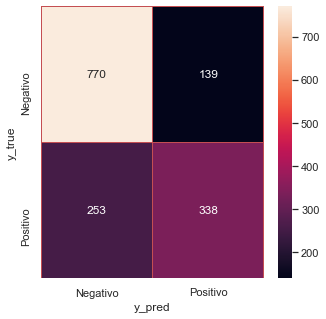

In [105]:
from sklearn.linear_model import LogisticRegression

params = {'penalty': ['l1', '‘l2', 'elasticnet', 'none'],
		  'tol': [0.0001, 0.001, 0.01, 0.1]}
		  
lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
print("Accuracy: ",lr_model.score(X_test,y_test))
print(lr_model.best_estimator_)
y_pred=lr_model.predict(X_test)
confusion(y_test,y_pred)

In [95]:
Errores_pos_lr = []
Errores_neg_lr = []
for i in range(1500):
    #print(y_test.iloc[i], y_pred[i])
    if y_test.iloc[i] != y_pred[i]:
        if y_test.iloc[i] == 0:
            Errores_neg_lr.append(y_test.index[i])
        else:
            Errores_pos_lr.append(y_test.index[i])
print(len(Errores_pos_lr))
print(len(Errores_neg_lr))

254
137


In [106]:
print(data.loc[Errores_neg_lr].groupby('stars').body_lemma.count())

stars
1    20
2    46
3    71
Name: body_lemma, dtype: int64


In [107]:
print(data.loc[Errores_pos_lr].groupby('stars').body_lemma.count())


stars
4    140
5    114
Name: body_lemma, dtype: int64


In [108]:
datos_neg = datos_neg.append(dev.iloc[Errores_neg_lr])
datos_pos = datos_pos.append(dev.iloc[Errores_pos_lr])

Miramos para estos dos predictores, los reviews que fueron difíciles de predecir para ambos. Desde ya vemos que 3 y 4 estrellas fueron los peor predichos en sus grupos respectivos para ambos modelos, pero que la mayoria de errores está en la categoria de buenos reviews. Exploramos más a countinuación:

In [109]:
repetidos_neg = [review_id for review_id in datos_neg.review_id.value_counts().index if datos_neg.review_id.value_counts()[review_id] == 2]
reviews_datos_neg = datos_neg.loc[datos_neg.review_id.isin(repetidos_neg)].drop_duplicates()

In [110]:
repetidos_pos = [review_id for review_id in datos_pos.review_id.value_counts().index if datos_pos.review_id.value_counts()[review_id] == 2]
reviews_datos_pos = datos_pos.loc[datos_pos.review_id.isin(repetidos_pos)].drop_duplicates()

In [112]:
reviews_datos_neg.review_body[:10]

2468    esta bien, pero lo esperaba más fuerte. de tod...
2846    es bonito el diseño, se adapta al movil perfec...
2138    positivo: llegó muy rápido el envío. negativo:...
2575    pequeña y fácil transporte. un poco ruidosa pe...
2357    es un regalo original para los que peinan bast...
1782    tal y como pongo, la carcasa esta bien, pero n...
2509    todo genial excepto que monta una sola rueda d...
2836    solicitado por el colegio, no tengo comentario...
2146    quedó perfecta y tal como esperaba en la pared...
2890    adaptador más bien inestable, calidad y dibujo...
Name: review_body, dtype: object

Observamos que estos reviews empiezan hablando de positivos antes de luego decir lo que no les gustó del producto. Si laparte positiva del review tiene mayor extensión que la negativa, será muy dificil que el modelo lo clasifique bien. 

Revisamos las reviews positivas tambien

In [ ]:
reviews_datos_pos.review_body[:10]